In [134]:
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt

In [135]:
b = 100
U_h = 3
U_up = 8
U_down = 6
R_up = 1.5
R_down = 1.5
u0 = 0

data = pd.read_excel('data.xlsx', index_col=0)



In [136]:
model = ConcreteModel()

# DEFINE SETS
model.T = Set(ordered=True, initialize=data.index)

# DEFINE PARAMETERS
model.lamb = Param(model.T, within=NonNegativeReals, mutable=True)

# INITIALIZE PARAMETERS
for t in model.T:
    model.lamb[t] = data.loc[t, 'price']

# DEFINE VARIABLES
model.u = Var(model.T, within=NonNegativeReals)

# DEFINE COST AND CONSTRAINTS
def cost_rule(model):
    return sum((model.lamb[t] - b)*model.u[t] for t in model.T)
model.cost = Objective(rule=cost_rule)

def ramp_up_rule(model, t):
    if model.T.ord(t) == 1:
        return model.u[t] - u0 <= R_up
    else:
        return model.u[t] - model.u[model.T.prev(t)] <= R_up
model.ramp_up = Constraint(model.T, rule=ramp_up_rule)

def ramp_down_rule(model, t):
    if model.T.ord(t) == 1:
        return model.u[t] - u0 >= -R_down
    else:
        return model.u[t] - model.u[model.T.prev(t)] >= -R_down
model.ramp_down = Constraint(model.T, rule=ramp_down_rule)

def max_consumption_rule(model, t):
    return model.u[t] <= U_h
model.max_consumption = Constraint(model.T, rule=max_consumption_rule)

def minmax_total_cons_rule(model):
    return inequality(U_down, sum(model.u[t] for t in model.T), U_up)
model.minmax_total_const = Constraint(rule=minmax_total_cons_rule)

In [137]:
model.pprint()

1 Set Declarations
    T : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=Insertion, Bounds=None
        ['t1', 't2', 't3', 't4']

1 Param Declarations
    lamb : Size=4, Index=T, Domain=NonNegativeReals, Default=None, Mutable=True
        Key : Value
         t1 :   120
         t2 :    75
         t3 :   110
         t4 :    60

1 Var Declarations
    u : Size=4, Index=T
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         t1 :     0 :  None :  None : False :  True : NonNegativeReals
         t2 :     0 :  None :  None : False :  True : NonNegativeReals
         t3 :     0 :  None :  None : False :  True : NonNegativeReals
         t4 :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (lamb[t1] -100)*u[t1] + (lamb[t2] -100)*u[t2] + (lamb[t3] -100)*u[t3] + (lamb[t4] -100)*u[t4]

4 Constraint Declarations
    max_co

In [138]:
opt = SolverFactory('gurobi')
results = opt.solve(model)

In [139]:
ideal_consumption = pd.DataFrame(index=data.index, columns=['Consumption', 'Price'])
for t in model.T:
    ideal_consumption.loc[t, 'Consumption'] = value(model.u[t])
    ideal_consumption.loc[t, 'Price'] = data.loc[t, 'price']
ideal_consumption

,Consumption,Price
t1,1,120
t2,2.5,75
t3,1.5,110
t4,3,60


Text(0, 0.5, 'Price ($/MWh)')

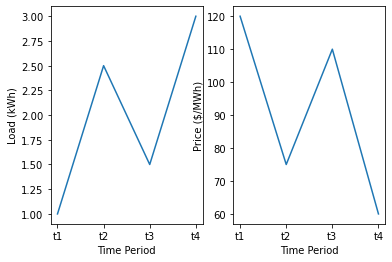

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

ideal_consumption['Consumption'].plot(ax=axes[0,0])
ideal_consumption['Price'].plot(ax=axes[0,1])
axes[0,0].set_xlabel('Time Period');axes[0,0].set_ylabel('Load (kWh)')
axes[0,1].set_xlabel('Time Period');axes[0,1].set_ylabel('Price ($/MWh)')